In [3]:
from __future__ import print_function
from keras.datasets import fashion_mnist
import keras
from keras.layers.core import Dense, Dropout
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.layers import Input
from keras.utils import np_utils
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from keras.regularizers import l2,l1
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score
os.environ['KMP_DUPLICATE_LIB_OK']='True'


Using TensorFlow backend.


In [4]:
# Data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [5]:
print(x_train.shape)
print(x_train[0].shape)
print(y_train.shape)
print(y_train[0])

(60000, 28, 28)
(28, 28)
(60000,)
9


# MLP

In [6]:
def prepare_data_for_MLP(x_train, y_train, x_test, y_test):
    num_classes = 10
    x_train = x_train.reshape(60000, 784)
    x_test = x_test.reshape(10000, 784)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    print('Data Loaded with Sample sizes')
    print('Train Sample Size: {}  '.format(x_train.shape[0]))
    print('Test Sample Size: {}'.format(x_test.shape[0]))
    return x_train, y_train, x_test, y_test

In [7]:
x_train_mlp, y_train_mlp, x_test_mlp, y_test_mlp = prepare_data_for_MLP(x_train, y_train, x_test, y_test)

Data Loaded with Sample sizes
Train Sample Size: 60000  
Test Sample Size: 10000


In [8]:
target_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot',
}

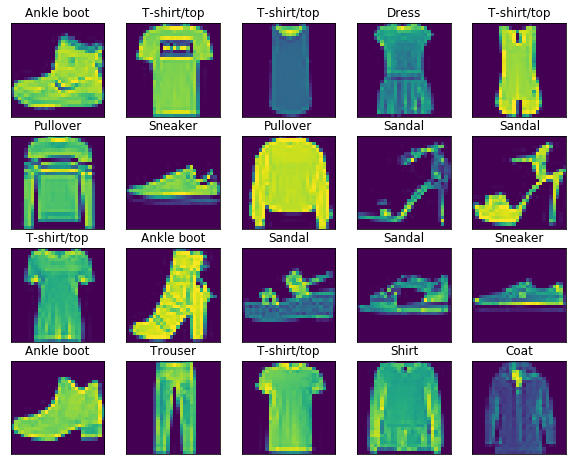

In [10]:
plt.figure(figsize=(10,10))
for i in range(0,20):
    plt.subplot(5,5, i+1)
    plt.imshow(x_train[i] )
    plt.title( target_dict[(y_train[i]) ])
    plt.xticks([])
    plt.yticks([])

In [14]:
class MLPModel:
    def __init__(self,x_train, y_train, x_test, y_test, epochs):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.epochs = epochs
        self.model = Sequential()

    
    def build_model(self, layers, activation, optimizer, regularization=None, dropout = 0.0):
        print(layers, activation, optimizer, regularization, dropout)
        for i in range(len(layers)):  
            if regularization:
                regu = l2(regularization[1]) if regularization[0] == 'l2' else l1(regularization[1])

            if i==0:
                # If First layer have to input size otherwise let it go
                self.model.add(Dense(layers[i], activation=activation, input_shape=self.x_train[0].shape, kernel_regularizer=regu))
            else:
                self.model.add(Dense(layers[i], activation=activation, kernel_regularizer=regu))

            if dropout:
                self.model.add(Dropout(dropout))
        
        self.model.add(Dense(10, activation='softmax'))
        self.model.summary()
        self.model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
        return self.model
    
    def train_model(self):
        return self.model.fit(self.x_train, self.y_train, batch_size=self.batch_size, epochs=self.epochs, verbose=2, validation_data=(self.x_test, self.y_test))      
        
    
    def print_head(self, n= 10):
        plt.figure(figsize=(20, 4))
        for i in range(1,n):
            ax = plt.subplot(2, n, i)
            plt.imshow(self.x_train[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()
        
        

In [15]:
parameters = { 'layers': [[512, 512], [512, 512, 512]], 
                     'activation': ['relu', 'elu'],
                     'optimizer' : ['adam'],
                     'dropout' : [0.2],
                     'regularization' : [ ('l2', 0.001) ]
                   }

In [ ]:

m = MLPModel(x_train_mlp, y_train_mlp, x_test_mlp, y_test_mlp, 5)
model = KerasClassifier(build_fn=m.build_model,epochs=5, batch_size=128)
grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=2)
grid_result = grid_search.fit(x_train_mlp, y_train_mlp)



/anaconda3/envs/MasterThesisEnv/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[512, 512] relu adam ('l2', 0.001) 0.2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
30000/30000 [==============================] - 17s 557us/step - loss: 1.2690 - acc: 0.7

# RandomForest

In [13]:
rf = RandomForestClassifier(n_estimators=64, n_jobs=-1)
rf.fit(x_train_mlp, y_train_mlp)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
y_pred_mlp = rf.predict(x_test_mlp)


In [15]:
# Print result
print(accuracy_score(y_test_mlp, y_pred_mlp))

0.8017


# Convulational Model

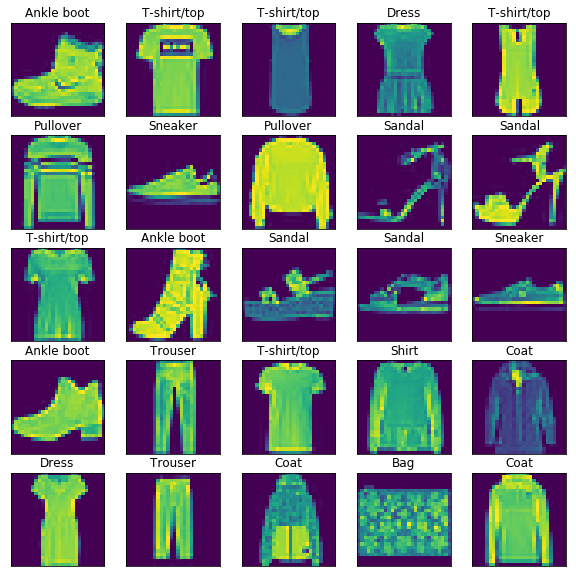

In [65]:
# See first 25 data

plt.figure(figsize=(10,10))
for i in range(0,25):
    plt.subplot(5,5, i+1)
    plt.imshow(x_train[i] )
    plt.title( target_dict[(y_train[i]) ])
    plt.xticks([])
    plt.yticks([])

In [66]:
class DataPreparation:
    def __init__(self, x_data, y_data, normalized=True):
        self. X = x_data.reshape(x_data.shape[0], 28,28,1)
        # One hot encoded
        self.Y = np_utils.to_categorical(y_data)
        
        if normalized:
            self.__normalize_data__()


    def __normalize_data__(self):
        self.X = self.X/np.float(255)

In [67]:
train_data  = DataPreparation(x_train, y_train)
test_data = DataPreparation(x_test, y_test)

In [68]:
print(train_data.Y[:5])
print(train_data.X.shape)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(60000, 28, 28, 1)


In [ ]:
parameters = {
    'layers' : [{'Conv2D' : 64, 'Conv2D' : 32}, {'Conv2D' : 64, 'Dense' : 32 } ],
    'activation' : ['relu']
    'optimizer' : ['adam'],
    'regularization' : [ ('l2', 0.001) ]
}

In [ ]:
class ConvolutionalModel:
    def __init__(self ,x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train
        self.model = Sequential()
    
    def build_model(self, layers, activation, optimizer, regularization=None, dropout = 0.0 ):
        if regularization:
                regularization = l2(regularization[1]) if regularization[0] == 'l2' else l1(regularization[1])
       
        i = 0
        for layer in layers:
            i+=1
            if i==1 :
                if layer == 'Conv2D':
                    model.add(Conv2D(layers[layer], kernel_size=3, activation=activation, input_shape=self.x_train.shape, regularization=regularization))
                else:
                    model.add(Dense(layers[layer], activation=activation, input_shape=self.x_train.shape, regularization=regularization))
            
            if layer == 'Conv2D':
                model.add(Conv2D(layers[layer], kernel_size=3, activation=activation, regularization=regularization))
            else:
                model.add(Dense(layers[layer], activation=activation, regularization=regularization))
            

        self.model.add(Flatten())
        self.model.add(Dense(10, activation='softmax'))
        self.model.summary()
        self.model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
        
        return self.model
        
    
    def fit(self, x_train, y_train, epochs=5):
        self.epochs = 5
        self.x_train, self.y_train = x_train, y_train
        
    
        
    
    
    
    
        
    
    
    
    
    